# Importing Libraries

In [1]:
import os
import torch
import collections
import numpy as np
import torch.nn.functional as F
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
from torch import nn
from torch import optim
from shutil import copy
from collections import defaultdict
from torchvision import datasets, transforms, models

# Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Looking for GPU

In [3]:
# Check whether GPU is available and if it is then use GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Unziping Dataset to Colab

In [ ]:
!unzip drive/MyDrive/Thesis/dataset.zip -d .

# Data Augmentation

In [5]:
# Data augmentation
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Use 10-crop for Test Time Augmentation
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.TenCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(crop) for crop in crops]))])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder("dataset/train", transform=train_transforms)
test_data = datasets.ImageFolder("dataset/test", transform=test_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=64, shuffle=True)

In [6]:
# Print out some data stats
print('Number of training images:', len(train_data))
print('Number of testing images:', len(test_data))

with open('drive/MyDrive/Thesis/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
print('Number of classes: ', len(classes))    

# Analyzing the shape of one batch
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print('Shape of first batch of training images:', train_images.shape)
print('Shape of first batch of test images:', test_images.shape) # 5-D array because of 10 crops

Number of training images: 75749
Number of testing images: 25250
Number of classes:  101
Shape of first batch of training images: torch.Size([64, 3, 224, 224])
Shape of first batch of test images: torch.Size([64, 10, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

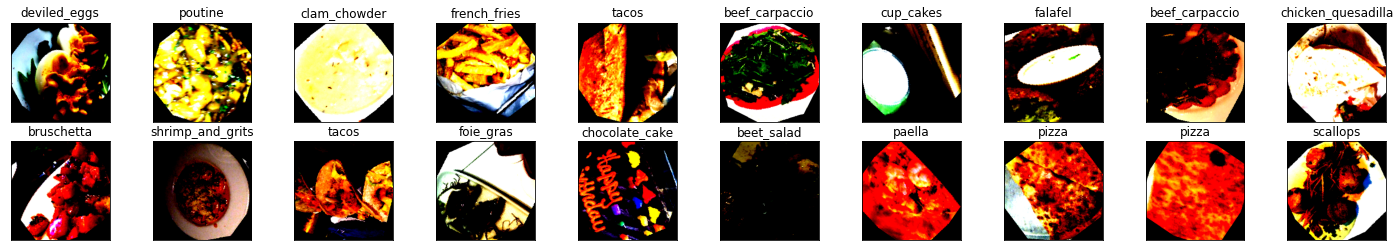

In [7]:
# Visualize some sample training data after Data augmentation

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

# Defining Model

In [8]:
# Load the ResNet-50 model pretraned on ImageNet 
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [9]:
# Freeze the initial layers
for param in model.parameters():
  param.requires_grad = False
  
# Replace the final fully connected layer with new fully connected layer of 101 neurons
classifier = nn.Linear(2048, 101)
model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training Loop

In [10]:
def training_loop(model, criterion, optimizer, scheduler, train_on_gpu, n_epochs, current_epoch, valid_loss, train_loader, val_loader, folder):

  # Print training info
  print('=' * 60)
  print('||  Training with ' + folder + ' for', n_epochs , 'epochs and lr:', optimizer.param_groups[0]['lr'])
  print("||  Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
  print('=' * 60)

  # Move the model to GPU if CUDA is available
  if train_on_gpu:
      model.cuda()

  valid_loss_min = valid_loss # track change in validation loss
  lr = optimizer.param_groups[0]['lr']

  for epoch in range(current_epoch + 1, current_epoch + n_epochs + 1):
      # Keep track of training and validation loss
      train_loss, train_accuracy, val_loss, val_accuracy = 0.0, 0.0, 0.0, 0.0
      print('_' * 60)
      print(f'Epoch {epoch}/{current_epoch + n_epochs} with learning rate {lr}')
      
      ###################   
      # Train the model #   
      ###################    
      model.train()
      for data, target in tq.tqdm(train_loader):
          # Move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # Clear the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: compute predicted outputs
          output = model(data)
          # Calculate the loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          # Calculate training accuracy
          top_p, top_class = output.topk(1, dim=1)
          equals = top_class == target.view(*top_class.shape)
          train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
          
      ######################    
      # Validate the model #    
      ######################     
      model.eval()
      with torch.no_grad():
          for data, target in tq.tqdm(val_loader):
              # Move tensors to GPU if CUDA is available
              if train_on_gpu:
                  data, target = data.cuda(), target.cuda()
              ## For 10-crop Testing
              bs, ncrops, c, h, w = data.size()
              # Forward pass: compute predicted outputs 
              temp_output = model(data.view(-1, c, h, w))
              output = temp_output.view(bs, ncrops, -1).mean(1)
              # Calculate the loss
              loss = criterion(output, target)
              # Update average validation loss 
              val_loss += loss.item()*data.size(0)
              # Calculate validation accuracy
              top_p, top_class = output.topk(1, dim=1)
              equals = top_class == target.view(*top_class.shape)
              val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
      

      # Calculate average losses and accuracies
      train_loss = train_loss/len(train_loader.dataset)
      train_accuracy = train_accuracy/len(train_loader.dataset)
      val_loss = val_loss/len(val_loader.dataset)
      val_accuracy = val_accuracy/len(val_loader.dataset)

      # Learning rate scheduler step
      scheduler.step(val_loss) 
      
      # print training/validation statistics 
      print('Train Loss: {:.4f} \tTrain Accuracy: {:.4f} \t\tValid Loss: {:.4f} \tValid Accuracy: {:.4f}'.format(train_loss, train_accuracy, val_loss, val_accuracy))
      
      # Save model if validation loss has decreased
      if val_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss))   
          checkpoint = {"model": model,
                        "criterion": criterion,
                        "epochs": epoch,
                        "optimizer_state": optimizer.state_dict(),
                        "model_state": model.state_dict(),
                        "valid_loss_min": val_loss,
                        "valid_accuracy": val_accuracy}

          # Save model in colab
          torch.save(checkpoint, 'best_so_far_checkpoint.pth')
          valid_loss_min = val_loss

          # Save model to google drive
          model_save_name = 'resnet50model.pth'
          path = F"drive/MyDrive/Thesis/checkpoints/{model_save_name}" 
          torch.save(checkpoint, path)

# Training Process (Frozen Weights)

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent with momentum)
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# specify learning rate scheduler (if there is no further decrease in loss for next 5 epochs then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 10, 0, np.Inf, train_loader, test_loader, 'frozen')

||  Training with frozen for 10 epochs and lr: 0.01
||  Trainable parameters: 206949
____________________________________________________________
Epoch 1/10 with learning rate 0.01



Train Loss: 3.1840 	Train Accuracy: 0.2721 		Valid Loss: 2.3777 	Valid Accuracy: 0.4185
Validation loss decreased (inf --> 2.377708).  Saving model ...
____________________________________________________________
Epoch 2/10 with learning rate 0.01



Train Loss: 2.7662 	Train Accuracy: 0.3487 		Valid Loss: 2.1338 	Valid Accuracy: 0.4708
Validation loss decreased (2.377708 --> 2.133782).  Saving model ...
____________________________________________________________
Epoch 3/10 with learning rate 0.01



Train Loss: 2.6888 	Train Accuracy: 0.3631 		Valid Loss: 2.1448 	Valid Accuracy: 0.4580
____________________________________________________________
Epoch 4/10 with learning rate 0.01



Train Loss: 2.6397 	Train Accuracy: 0.3759 		Valid Loss: 2.0461 	Valid Accuracy: 0.4792
Validation loss decreased (2.133782 --> 2.046076).  Saving model ...
____________________________________________________________
Epoch 5/10 with learning rate 0.01



Train Loss: 2.6107 	Train Accuracy: 0.3806 		Valid Loss: 2.1190 	Valid Accuracy: 0.4692
____________________________________________________________
Epoch 6/10 with learning rate 0.01



Train Loss: 2.5861 	Train Accuracy: 0.3849 		Valid Loss: 2.0237 	Valid Accuracy: 0.4875
Validation loss decreased (2.046076 --> 2.023682).  Saving model ...
____________________________________________________________
Epoch 7/10 with learning rate 0.01



Train Loss: 2.5654 	Train Accuracy: 0.3887 		Valid Loss: 2.0793 	Valid Accuracy: 0.4697
____________________________________________________________
Epoch 8/10 with learning rate 0.01



Train Loss: 2.5449 	Train Accuracy: 0.3923 		Valid Loss: 1.9285 	Valid Accuracy: 0.5129
Validation loss decreased (2.023682 --> 1.928480).  Saving model ...
____________________________________________________________
Epoch 9/10 with learning rate 0.01



Train Loss: 2.5416 	Train Accuracy: 0.3944 		Valid Loss: 1.9667 	Valid Accuracy: 0.5007
____________________________________________________________
Epoch 10/10 with learning rate 0.01



Train Loss: 2.5291 	Train Accuracy: 0.3969 		Valid Loss: 1.9494 	Valid Accuracy: 0.5094


# Training Process (Unfrozen Weights)

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [ ]:
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 9th epoch and a validation loss of 1.6318


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 20, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen')

||  Training with unfrozen for 20 epochs and lr: 0.01
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 10/29 with learning rate 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 1.8407 	Train Accuracy: 0.5398 		Valid Loss: 1.1991 	Valid Accuracy: 0.6812
Validation loss decreased (1.631781 --> 1.199080).  Saving model ...
____________________________________________________________
Epoch 11/29 with learning rate 0.01



Train Loss: 1.6889 	Train Accuracy: 0.5743 		Valid Loss: 1.1089 	Valid Accuracy: 0.7038
Validation loss decreased (1.199080 --> 1.108923).  Saving model ...
____________________________________________________________
Epoch 12/29 with learning rate 0.01



Train Loss: 1.5806 	Train Accuracy: 0.5998 		Valid Loss: 0.9943 	Valid Accuracy: 0.7337
Validation loss decreased (1.108923 --> 0.994349).  Saving model ...
____________________________________________________________
Epoch 13/29 with learning rate 0.01



Train Loss: 1.4920 	Train Accuracy: 0.6210 		Valid Loss: 0.9329 	Valid Accuracy: 0.7470
Validation loss decreased (0.994349 --> 0.932889).  Saving model ...
____________________________________________________________
Epoch 14/29 with learning rate 0.01



Train Loss: 1.4289 	Train Accuracy: 0.6348 		Valid Loss: 0.8554 	Valid Accuracy: 0.7635
Validation loss decreased (0.932889 --> 0.855445).  Saving model ...
____________________________________________________________
Epoch 15/29 with learning rate 0.01


# Training Process (Unfrozen Weights) II
Continuation of Training due to Colab Disconnection

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [ ]:
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 14th epoch and a validation loss of 0.8554


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 16, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen')

||  Training with unfrozen for 16 epochs and lr: 0.01
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 15/30 with learning rate 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 1.3791 	Train Accuracy: 0.6454 		Valid Loss: 0.8465 	Valid Accuracy: 0.7656
Validation loss decreased (0.855445 --> 0.846478).  Saving model ...
____________________________________________________________
Epoch 16/30 with learning rate 0.01



Train Loss: 1.3236 	Train Accuracy: 0.6576 		Valid Loss: 0.9201 	Valid Accuracy: 0.7485
____________________________________________________________
Epoch 17/30 with learning rate 0.01



Train Loss: 1.2846 	Train Accuracy: 0.6666 		Valid Loss: 0.7660 	Valid Accuracy: 0.7913
Validation loss decreased (0.846478 --> 0.765974).  Saving model ...
____________________________________________________________
Epoch 18/30 with learning rate 0.01



Train Loss: 1.2517 	Train Accuracy: 0.6749 		Valid Loss: 0.7690 	Valid Accuracy: 0.7863
____________________________________________________________
Epoch 19/30 with learning rate 0.01


# Training Process (Unfrozen Weights) IIΙ
Continuation of Training due to Colab Disconnection

In [ ]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch  = checkpoint['epochs']

In [ ]:
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 17th epoch and a validation loss of 0.7660


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 23, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen')

||  Training with unfrozen for 23 epochs and lr: 0.01
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 18/40 with learning rate 0.01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 1.2421 	Train Accuracy: 0.6770 		Valid Loss: 0.8114 	Valid Accuracy: 0.7760
____________________________________________________________
Epoch 19/40 with learning rate 0.01



Train Loss: 1.2069 	Train Accuracy: 0.6851 		Valid Loss: 0.7943 	Valid Accuracy: 0.7812
____________________________________________________________
Epoch 20/40 with learning rate 0.01



Train Loss: 1.1763 	Train Accuracy: 0.6931 		Valid Loss: 0.6891 	Valid Accuracy: 0.8083
Validation loss decreased (0.765974 --> 0.689118).  Saving model ...
____________________________________________________________
Epoch 21/40 with learning rate 0.01



Train Loss: 1.1433 	Train Accuracy: 0.7000 		Valid Loss: 0.7166 	Valid Accuracy: 0.8014
____________________________________________________________
Epoch 22/40 with learning rate 0.01



Train Loss: 1.1115 	Train Accuracy: 0.7076 		Valid Loss: 0.7080 	Valid Accuracy: 0.8064
____________________________________________________________
Epoch 23/40 with learning rate 0.01



Train Loss: 1.0987 	Train Accuracy: 0.7113 		Valid Loss: 0.7152 	Valid Accuracy: 0.8054
____________________________________________________________
Epoch 24/40 with learning rate 0.01


# Training Process (Unfrozen Weights) IV

In [11]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch  = checkpoint['epochs']

In [12]:
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 24th epoch and a validation loss of 0.5256


In [ ]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [ ]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 20, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen')

||  Training with unfrozen for 20 epochs and lr: 0.002
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 21/40 with learning rate 0.002


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 0.9390 	Train Accuracy: 0.7523 		Valid Loss: 0.5462 	Valid Accuracy: 0.8466
Validation loss decreased (0.689118 --> 0.546218).  Saving model ...
____________________________________________________________
Epoch 22/40 with learning rate 0.002



Train Loss: 0.8724 	Train Accuracy: 0.7684 		Valid Loss: 0.5383 	Valid Accuracy: 0.8503
Validation loss decreased (0.546218 --> 0.538339).  Saving model ...
____________________________________________________________
Epoch 23/40 with learning rate 0.002



Train Loss: 0.8419 	Train Accuracy: 0.7763 		Valid Loss: 0.5456 	Valid Accuracy: 0.8512
____________________________________________________________
Epoch 24/40 with learning rate 0.002



Train Loss: 0.8115 	Train Accuracy: 0.7821 		Valid Loss: 0.5256 	Valid Accuracy: 0.8550
Validation loss decreased (0.538339 --> 0.525562).  Saving model ...
____________________________________________________________
Epoch 25/40 with learning rate 0.002



Train Loss: 0.7951 	Train Accuracy: 0.7856 		Valid Loss: 0.5366 	Valid Accuracy: 0.8526
____________________________________________________________
Epoch 26/40 with learning rate 0.002



Train Loss: 0.7839 	Train Accuracy: 0.7909 		Valid Loss: 0.5361 	Valid Accuracy: 0.8510
____________________________________________________________
Epoch 27/40 with learning rate 0.002



Train Loss: 0.7671 	Train Accuracy: 0.7941 		Valid Loss: 0.5328 	Valid Accuracy: 0.8506
____________________________________________________________
Epoch 28/40 with learning rate 0.002


# Training Process (Unfrozen Weights) V

In [13]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Check the saved model's last epoch and last validation loss
valid_loss = checkpoint["valid_loss_min"] 
num_epoch  = checkpoint['epochs']

In [14]:
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 24th epoch and a validation loss of 0.5256


In [15]:
# specify loss function (categorical cross-entropy) same as used earlier
criterion = nn.CrossEntropyLoss()

# specify optimizer same as used earlier
optimizer = optim.SGD(model.parameters(), lr=0.0004, momentum=0.9)

# specify scheduler same as used earlier
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

In [16]:
training_loop(model, criterion, optimizer, scheduler, train_on_gpu, 6, num_epoch, valid_loss, train_loader, test_loader, 'unfrozen')

||  Training with unfrozen for 6 epochs and lr: 0.0004
||  Trainable parameters: 23714981
____________________________________________________________
Epoch 25/30 with learning rate 0.0004


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Train Loss: 0.7487 	Train Accuracy: 0.7995 		Valid Loss: 0.5148 	Valid Accuracy: 0.8577
Validation loss decreased (0.525562 --> 0.514816).  Saving model ...
____________________________________________________________
Epoch 26/30 with learning rate 0.0004



Train Loss: 0.7413 	Train Accuracy: 0.8012 		Valid Loss: 0.5165 	Valid Accuracy: 0.8592
____________________________________________________________
Epoch 27/30 with learning rate 0.0004



Train Loss: 0.7313 	Train Accuracy: 0.8038 		Valid Loss: 0.5056 	Valid Accuracy: 0.8611
Validation loss decreased (0.514816 --> 0.505608).  Saving model ...
____________________________________________________________
Epoch 28/30 with learning rate 0.0004



Train Loss: 0.7219 	Train Accuracy: 0.8072 		Valid Loss: 0.5146 	Valid Accuracy: 0.8590
____________________________________________________________
Epoch 29/30 with learning rate 0.0004



Train Loss: 0.7150 	Train Accuracy: 0.8082 		Valid Loss: 0.5084 	Valid Accuracy: 0.8596
____________________________________________________________
Epoch 30/30 with learning rate 0.0004



Train Loss: 0.7124 	Train Accuracy: 0.8081 		Valid Loss: 0.5086 	Valid Accuracy: 0.8607


# Evaluation

In [17]:
# Load the saved model from last checkpoint
checkpoint = torch.load("drive/MyDrive/Thesis/checkpoints/resnet50model.pth", map_location='cpu')

# Use entire network for training
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 101)
model.load_state_dict(checkpoint['model_state'], strict=False)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Print the Validation Loss and Total Epochs
valid_loss = checkpoint["valid_loss_min"] 
num_epoch  = checkpoint['epochs']
print(f'We have reached the {num_epoch}th epoch and a validation loss of {valid_loss:.4f}')

We have reached the 27th epoch and a validation loss of 0.5056


In [19]:
######################    
# Evaluate the model #    
######################     
test_loss = 0.0
true_class = list(0. for i in range(len(classes)))
total_class = list(0. for i in range(len(classes)))

model.cuda()
model.eval()

with torch.no_grad():
    for data, target in tq.tqdm(test_loader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        ## For 10-crop Testing
        bs, ncrops, c, h, w = data.size()
        # Forward pass: compute predicted outputs 
        temp_output = model(data.view(-1, c, h, w))
        output = temp_output.view(bs, ncrops, -1).mean(1)
        # Calculate the loss
        loss = criterion(output, target)
        # Update average evaluation loss 
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        # Comparing true and predicted labels
        true_labels = pred.eq(target.data.view_as(pred))
        true_labels = np.squeeze(true_labels.numpy()) if not train_on_gpu else np.squeeze(true_labels.cpu().numpy())
        # Calculate class-wise accuracy
        for i in range(len(target)):
            label = target.data[i]
            true_class[label]  += true_labels[i].item() # Auto na dw ti kanei
            total_class[label] += 1

# Calculate average loss
val_loss = test_loss/len(test_loader.dataset)

# Prin per class accuracies
for i in range(len(classes)):
    print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (classes[i], 100 * true_class[i] / total_class[i], np.sum(true_class[i]), np.sum(total_class[i])))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (100. * np.sum(true_class) / np.sum(total_class), np.sum(true_class), np.sum(total_class)))


Test Accuracy of apple_pie: 66.40% (166/250)
Test Accuracy of baby_back_ribs: 77.20% (193/250)
Test Accuracy of baklava: 92.00% (230/250)
Test Accuracy of beef_carpaccio: 91.60% (229/250)
Test Accuracy of beef_tartare: 86.80% (217/250)
Test Accuracy of beet_salad: 80.80% (202/250)
Test Accuracy of beignets: 92.40% (231/250)
Test Accuracy of bibimbap: 92.40% (231/250)
Test Accuracy of bread_pudding: 69.60% (174/250)
Test Accuracy of breakfast_burrito: 75.60% (189/250)
Test Accuracy of bruschetta: 73.60% (184/250)
Test Accuracy of caesar_salad: 90.80% (227/250)
Test Accuracy of cannoli: 93.60% (234/250)
Test Accuracy of caprese_salad: 90.00% (225/250)
Test Accuracy of carrot_cake: 81.20% (203/250)
Test Accuracy of ceviche: 78.80% (197/250)
Test Accuracy of cheesecake: 92.40% (231/250)
Test Accuracy of cheese_plate: 73.60% (184/250)
Test Accuracy of chicken_curry: 80.40% (201/250)
Test Accuracy of chicken_quesadilla: 88.00% (220/250)
Test Accuracy of chicken_wings: 92.80% (232/250)
Test 